In [18]:
# ==============================================================
# ENHANCED SENTIMENT ANALYSIS (Twitter Dataset)
# ==============================================================

# STEP 1: Import libraries
import pandas as pd
import numpy as np
import re, string
import seaborn as sns
import matplotlib.pyplot as plt
import joblib, warnings
warnings.filterwarnings("ignore")

# NLP Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

In [19]:
# --------------------------------------------------------------
# STEP 2: Load Dataset
# --------------------------------------------------------------
df = pd.read_csv("dataset.csv")   # replace with actual file
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print(df.head())

# Adjust column names if necessary
df.rename(columns={df.columns[0]:'id', df.columns[1]:'entity',
                   df.columns[2]:'sentiment', df.columns[3]:'text'}, inplace=True)

df = df[['sentiment','text']].dropna()
print("\nUnique Sentiments:", df['sentiment'].unique())

Dataset Shape: (74681, 4)

Columns: ['2401', 'Borderlands', 'Positive', 'im getting on borderlands and i will murder you all ,']
   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     

Unique Sentiments: ['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [20]:
# --------------------------------------------------------------
# STEP 3: Advanced Data Cleaning
# --------------------------------------------------------------
nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)
print("\nSample cleaned tweets:\n", df[['text','clean_text']].head())

# Encode labels uniformly
df['sentiment'] = df['sentiment'].map({
    "Positive":"positive", "Negative":"negative",
    "Neutral":"neutral", "Irrelevant":"irrelevant"
})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Sample cleaned tweets:
                                                 text  \
0  I am coming to the borders and I will kill you...   
1  im getting on borderlands and i will kill you ...   
2  im coming on borderlands and i will murder you...   
3  im getting on borderlands 2 and i will murder ...   
4  im getting into borderlands and i can murder y...   

                     clean_text  
0            coming border kill  
1    im getting borderland kill  
2   im coming borderland murder  
3  im getting borderland murder  
4  im getting borderland murder  


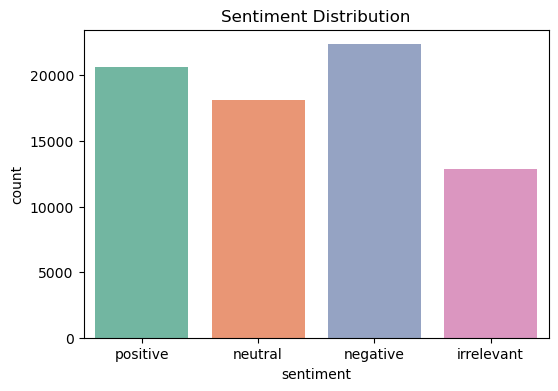


Class distribution:
 sentiment
negative      22358
positive      20654
neutral       18108
irrelevant    12875
Name: count, dtype: int64


In [21]:
# --------------------------------------------------------------
# STEP 4: Class Distribution
# --------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'], palette="Set2")
plt.title("Sentiment Distribution")
plt.show()

print("\nClass distribution:\n", df['sentiment'].value_counts())

In [22]:
# --------------------------------------------------------------
# STEP 5: Split Data
# --------------------------------------------------------------
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nTrain size:", len(X_train), " | Test size:", len(X_test))



Train size: 59196  | Test size: 14799


In [25]:
# --------------------------------------------------------------
# STEP 6: Vectorization (TF-IDF with bigrams)
# --------------------------------------------------------------
tfidf = TfidfVectorizer(stop_words="english", max_features=10000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)
print("TF-IDF vectorized:", X_train_vec.shape)

TF-IDF vectorized: (59196, 10000)


In [ ]:
# --------------------------------------------------------------
# STEP 7: Train & Evaluate Models
# --------------------------------------------------------------
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
}

results = []

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append([name, acc, prec, rec, f1])

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, zero_division=0))


=== MultinomialNB ===
              precision    recall  f1-score   support

  irrelevant       0.79      0.39      0.52      2575
    negative       0.64      0.83      0.72      4472
     neutral       0.70      0.57      0.63      3621
    positive       0.66      0.76      0.70      4131

    accuracy                           0.67     14799
   macro avg       0.70      0.64      0.64     14799
weighted avg       0.69      0.67      0.66     14799


=== BernoulliNB ===
              precision    recall  f1-score   support

  irrelevant       0.65      0.53      0.58      2575
    negative       0.72      0.73      0.73      4472
     neutral       0.72      0.51      0.60      3621
    positive       0.59      0.81      0.68      4131

    accuracy                           0.66     14799
   macro avg       0.67      0.64      0.65     14799
weighted avg       0.67      0.66      0.66     14799


=== LogisticRegression ===
              precision    recall  f1-score   support

  i


Model Performance Comparison:
                 Model  Accuracy  Precision    Recall        F1
0       MultinomialNB  0.670383   0.685428  0.670383  0.659689
1         BernoulliNB  0.662680   0.673913  0.662680  0.657768
2  LogisticRegression  0.723089   0.724203  0.723089  0.719639


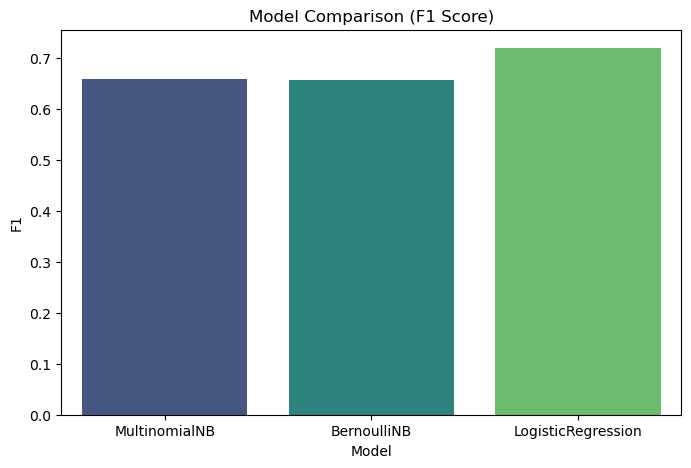

In [37]:
# --------------------------------------------------------------
# STEP 8: Results Comparison
# --------------------------------------------------------------
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
print("\nModel Performance Comparison:\n", results_df)

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="F1", data=results_df, palette="viridis")
plt.title("Model Comparison (F1 Score)")
plt.show()

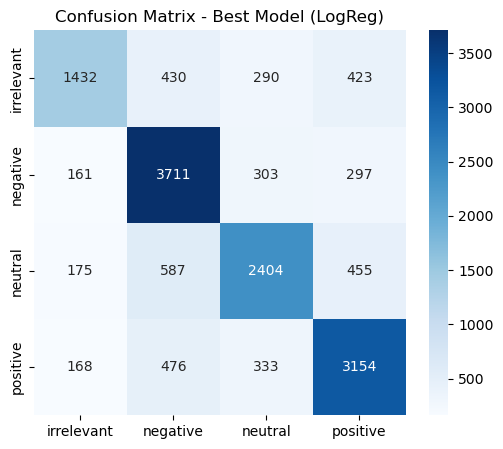

In [39]:
# --------------------------------------------------------------
# STEP 9: Confusion Matrix for Best Model
# --------------------------------------------------------------
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_vec, y_train)
y_pred_best = best_model.predict(X_test_vec)

cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Confusion Matrix - Best Model (LogReg)")
plt.show()

In [41]:
# --------------------------------------------------------------
# STEP 10: Save Model
# --------------------------------------------------------------
joblib.dump(best_model, "sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("\n✅ Best model (Logistic Regression) saved successfully.")


✅ Best model (Logistic Regression) saved successfully.
